In [1]:
import os
import keras
import pprint
import numpy as np
import matplotlib.pyplot as plt
from keras import applications
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from PIL import Image
%matplotlib inline

traindir = '/home/saniea/imagedata/kerastut/train/'
valdir = '/home/saniea/imagedata/kerastut/validate/'
testdir = '/home/saniea/imagedata/kerastut/test/'

Using TensorFlow backend.


In [2]:
'''
This is this is the basic network. Works without any pretrained network. Works with very little data, only 2000
images per class to train and 400 per class to validate
reaches 86% validation accuracy
TODO: figure out how to test this network using images from test data
'''

# batch_size = 16

# # this is the augmentation configuration we will use for training
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)


# # this is the augmentation configuration we will use for testing:
# # only rescaling
# val_datagen = ImageDataGenerator(rescale=1./255)


# # this is a generator that will read pictures found in
# # subfolers of 'data/train', and indefinitely generate
# # batches of augmented image data
# train_generator = train_datagen.flow_from_directory(
#         traindir,  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# # this is a similar generator, for validation data
# validation_generator = val_datagen.flow_from_directory(
#         valdir,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary')

# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # the model so far outputs 3D feature maps (height, width, features)

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# model.fit_generator(
#         train_generator,
#         steps_per_epoch=2000 // batch_size,
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=800 // batch_size)
# model.save_weights('first_try.h5')  # always save your weights after training or during training

'\nThis is this is the basic network. Works without any pretrained network. Works with very little data, only 2000\nimages per class to train and 400 per class to validate\nreaches 86% validation accuracy\nTODO: figure out how to test this network using images from test data\nTODO: figure out how to expand problem to more than two classes\n'

In [3]:
'''
This part of the code uses the weights generated from the bottleneck feature usage in the previous part and the just
fine tunes the top CNN block of the ImageNet network. Weights for the whole CNN block are generated, 4/5 blocks are
frozen to prevent any further changes. After this, our own top layer is place on the network, weights are trained and
generated
'''

'\nThis part of the code uses the weights generated from the bottleneck feature usage in the previous part and the just\nfine tunes the top CNN block of the ImageNet network. Weights for the whole CNN block are generated, 4/5 blocks are\nfrozen to prevent any further changes. After this, our own top layer is place on the network, weights are trained and\ngenerated\n'

In [2]:
def save_bottleneck_features():
    
    files = os.listdir(".")
    for file in files:
        if file.startswith('bottleneck'):
            os.remove(file)
            
    datagen = ImageDataGenerator(rescale=1./255)
    # build VGG16 network
    vgg_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
    print("VGG Model Loaded")
    
    generator = datagen.flow_from_directory(
            traindir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data

    bottleneck_features_train = vgg_model.predict_generator(generator, 3000//batch_size)

    # save the output as a Numpy array
    np.save(open('bottleneck_features_train', 'wb'), bottleneck_features_train)
    print("Training features generated and saved")

    generator = datagen.flow_from_directory(
            valdir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    
    bottleneck_features_validation = vgg_model.predict_generator(generator, 1200//batch_size)
    np.save(open('bottleneck_features_validation', 'wb'), bottleneck_features_validation)
    
    print("Validation features generated and saved")

    return vgg_model

def train_weights():
    
    # the features were saved in order, so recreating the labels is easy
    train_data = np.load(open('bottleneck_features_train','rb'))
    train_labels = np.array([0] * 1000 + [1] * 1000 + [2] * 1000)
    train_labels = to_categorical(train_labels)

    validation_data = np.load(open('bottleneck_features_validation', 'rb'))
    validation_labels = np.array([0] * 400 + [1] * 400 + [2] * 400)
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    model.fit(train_data, train_labels,
              epochs=60,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    print("Top model weights trained")

def build_top_model(vgg_model):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='sigmoid'))

    # note that it is necessary to start with a fully-trained
    # classifier, including the top classifier,
    # in order to successfully do fine-tuning
    top_model.load_weights(top_model_weights_path)
    print("Top model built")

    return top_model

def composite_model(vgg_model, top_model):
    # # add the model on top of the convolutional base
    # model.add(top_model)
    model=Model(input=vgg_model.input, output=top_model(vgg_model.output))
    print("Final model built")

    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:15]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-6, momentum=0.9),
                  metrics=['categorical_accuracy'])
   
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        traindir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        valdir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    
    print("Beginning model fitting")
    # fine-tune the model
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=3000//batch_size,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=1200//batch_size)
        
    model.summary()
    
    with open('model_history', 'wb') as f:
        pickle.dump(hist.history, f)
    

In [3]:
batch_size = 15
top_model_weights_path = 'fc_model.h5'
vgg_model = save_bottleneck_features()
train_weights()
top_model = build_top_model(vgg_model)
composite_model(vgg_model, top_model)

VGG Model Loaded
Found 3000 images belonging to 3 classes.
Training features generated and saved
Found 1200 images belonging to 3 classes.
Validation features generated and saved
Train on 3000 samples, validate on 1200 samples
Epoch 1/60
3000/3000 [==============================] - 8s 3ms/step - loss: 1.0377 - categorical_accuracy: 0.3630 - val_loss: 1.0975 - val_categorical_accuracy: 0.3108
Epoch 2/60
3000/3000 [==============================] - 1s 333us/step - loss: 0.9702 - categorical_accuracy: 0.5037 - val_loss: 0.6887 - val_categorical_accuracy: 0.7925
Epoch 3/60
3000/3000 [==============================] - 1s 333us/step - loss: 0.5392 - categorical_accuracy: 0.7997 - val_loss: 0.4206 - val_categorical_accuracy: 0.8908
Epoch 4/60
3000/3000 [==============================] - 1s 332us/step - loss: 0.2949 - categorical_accuracy: 0.8800 - val_loss: 0.3101 - val_categorical_accuracy: 0.9058
Epoch 5/60
3000/3000 [==============================] - 1s 340us/step - loss: 0.1828 - categori

/home/saniea/miniconda2/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


Found 1200 images belonging to 3 classes.
Beginning model fitting
Epoch 1/60
200/200 [==============================] - 37s 187ms/step - loss: 0.4010 - categorical_accuracy: 0.9230 - val_loss: 0.5885 - val_categorical_accuracy: 0.9075
Epoch 2/60
200/200 [==============================] - 35s 176ms/step - loss: 0.3589 - categorical_accuracy: 0.9297 - val_loss: 0.5716 - val_categorical_accuracy: 0.9058
Epoch 3/60
200/200 [==============================] - 35s 175ms/step - loss: 0.2964 - categorical_accuracy: 0.9347 - val_loss: 0.5496 - val_categorical_accuracy: 0.9058
Epoch 4/60
200/200 [==============================] - 35s 176ms/step - loss: 0.3355 - categorical_accuracy: 0.9233 - val_loss: 0.5357 - val_categorical_accuracy: 0.9058
Epoch 5/60
200/200 [==============================] - 35s 176ms/step - loss: 0.2724 - categorical_accuracy: 0.9357 - val_loss: 0.5227 - val_categorical_accuracy: 0.9067
Epoch 6/60
200/200 [==============================] - 35s 177ms/step - loss: 0.3007 - cat

Epoch 49/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1414 - categorical_accuracy: 0.9520 - val_loss: 0.3760 - val_categorical_accuracy: 0.9108
Epoch 50/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1474 - categorical_accuracy: 0.9580 - val_loss: 0.3741 - val_categorical_accuracy: 0.9100
Epoch 51/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1330 - categorical_accuracy: 0.9547 - val_loss: 0.3725 - val_categorical_accuracy: 0.9100
Epoch 52/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1358 - categorical_accuracy: 0.9540 - val_loss: 0.3751 - val_categorical_accuracy: 0.9158
Epoch 53/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1666 - categorical_accuracy: 0.9457 - val_loss: 0.3721 - val_categorical_accuracy: 0.9125
Epoch 54/60
200/200 [==============================] - 35s 176ms/step - loss: 0.1642 - categorical_accuracy: 0.9507 - val_loss: 0.3716 - val_categoric

In [4]:
with open('model_history', 'rb') as f:
    hist = pickle.load(f)

print (hist.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


/home/saniea/miniconda2/envs/thesis/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


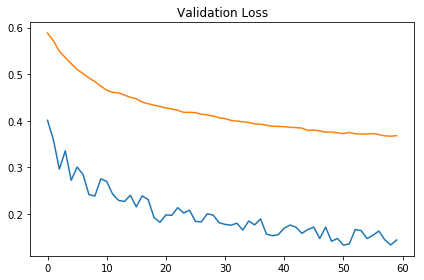

In [9]:
with open('model_history', 'rb') as f:
    hist = pickle.load(f)

key2name = {'categorical_accuracy':'Accuracy', 'loss':'Loss', 
    'val_categorical_accuracy':'Validation Accuracy', 'val_loss':'Validation Loss'}

fig = plt.figure()

# things = ['categorical_accuracy','loss','val_categorical_accuracy','val_loss']
things = ['loss','val_loss']
for i,thing in enumerate(things):
    trace = hist[thing]
#     plt.subplot(2,2,i+1)
    plt.plot(range(len(trace)),trace)
    plt.title(key2name[thing])

# fig.set_tight_layout(True)